# Cas3-Derived Target DNA Degradation Fragments Fuel Primed CRISPR Adaptation

Текст статьи: https://www.cell.com/molecular-cell/fulltext/S1097-2765(16)30364-1 
Файлы с "сырыми" данными: https://www.ebi.ac.uk/ena/data/search?query=PRJEB13999 (ENA)

Риды из "сырых" файлов были очищенны от адаптеров и из них были отобраны только те, которые картируются на последовательность используемой в эксперименте плазмиды. Последовательность плазмиды не была опубликована в статье, но ее предоставили нам коллеги.

Данный скрипт предназначен для сортировки и обработки очищенных ридов, записанных в SAM файл. Риды - результат секвенирования линейных молекул ДНК, полученных в результате специфичного (предположительно) разрезания кольцевой плазмиды каспазой Cas3. Для определения сайтов разрезания нам требовалось определить позиции на которые картируются 5'-концы ридов и посчитать частоты оснований, встречающихся на этих позициях в плазмиде. Таргетной (target) цепью считается прямая, не таргетной (nontarget) обратная.

Для выполнения задачи требуются модули: numpy, pandas, matplotlib.pyplot, matplotlib, seaborn и функция Counter из модуля collections.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import Counter

При считывании SAM файла была пропущена первая строка с заглавиями столбцов. Далее считанные строки были разбиты по табулятору. (На выходе имеем список списков, где в каждом вложенном списке индекс элемента соответствует номеру столбца в исходном файле)

In [5]:
with open('data/Galaxy84_Filter_SAM_or_BAM,_outp.sam') as samfile:
    for _i in range(3):
        samfile.readline()
    lines = samfile.readlines()
    
columns = map(lambda x: x.split('\t'), lines)

Во 2м столбце SAM файла записывается информация о риде с использованием двоичного маскирования. Побитовый разбор можно посмотреть здесь: https://davetang.org/wiki/tiki-index.php?page=SAM.

Используя побитовый "and" мы отфильтровали риды по их принадлежности к нужным нам классам. То есть проверялось, что на нужной позиции в нашей записи стоит 0 или 1.

Позиции следующие: ноль на позиции 0x0004 означает, что рид картировался на референсную последовательность; ноль на позиции 0x0008 означает, что рид парный; то, что на позициях 0x0010 и 0x0020 стоят разные числа, означает, что и рид и его "пара" выровнялись на разные цепи.

In [6]:
filter1 = filter(lambda x: (int(x[1]) & 0x0004) == 0, columns)
# Find only mapped sequences

filter2 = filter(lambda x: (int(x[1]) & 0x0008) == 0, filter1)
# Find only pair mapped reads

filter3 = list(filter(lambda x: ((int(x[1]) & 0x0010) == 0) != ((int(x[1]) & 0x0020) == 0),
                      filter2))
# Find reads itself and it's mate mapped within the differnt chain

Для дальнейшей работы потребовалось ввести функцию, которая будет сортировать риды по их принадлежности к типам f1 (первый рид в паре выравнивается на прямую цепь), f2 (второй рид в паре выравнивается на прямую цепь), r1 (первый рид в паре выравнивается на обратную цепь), r2 (второй рид в паре выравнивается на обратную цепь). 

In [7]:
# Sort readings based on how they are mapped

def typy(a):
    i = int(a[1])
    if (i & 0x10) and (i & 0x40):
        reverse_first.append(a)
    elif (i & 0x20) and (i & 0x40):
        forward_first.append(a)
    elif (i & 0x10) and (i & 0x80):
        reverse_second.append(a)
    elif (i & 0x20) and (i & 0x80):
        forward_second.append(a)

Риды сортируются и записываются в 4 разных списка.

In [8]:
reverse_first = []
forward_first = []
reverse_second = []
forward_second = []

for a in filter3:
    typy(a)

Далее требовалось рассчитать покрытие каждой позиции в последовательности плазмиды КОНЦАМИ ридов. В SAM файле записаны координаты начал ридов, но, если для f1 и f2 можно брать непосредственно эти числа, то для r1 и r2 (т.к. это получается координата 3'-конца) нужно прибавить к указанной координате начала длину рида (вычисляется как длина строки с последовательностью рида). В виде комментариев внутри функций изображены рассматриваемые случаи, звездочками помечены первые риды в паре.

Функция r_starts работает с обратной цепью. Она возвращает словарь, в котором ключами являются позиции, а соответствующими значениями то, сколько концов ридов попадает на соответствующую позицию.

In [9]:
def r_starts():
    d = {}
    for a in forward_second:
        p = int(a[3]) # начало рида - не правильно - fixed
        # 2|----->               *
        #                 <!-----|1 non target
        d[p] = d.get(p,0) + 1
    for a in reverse_first:
        # 2|-----!>
        #  *               <------|1
        p = int(a[3]) + len(a[9]) - 1 # не правильно - fixed
        d[p] = d.get(p,0) + 1
    return d

Функция f_starts работает с прямой цепью. Она также возвращает словарь, в котором ключами являются позиции, а соответствующими значениями то, сколько концов ридов попадает на соответствующую позицию.

In [10]:
def f_starts():
    d = {}
    for a in forward_first:
        # 1|---!> 
        #  *        <----|2
        p = int(a[3]) # все ок
        d[p] = d.get(p,0) + 1
    for a in reverse_second:
        # 1|----->        *
        #           <!----|2
        p = int(a[3]) + len(a[9]) - 1 # все ок
        d[p] = d.get(p,0) + 1
    return d

Получены вышеописанные словари: 1й для прямой и 2й для обратной цепи. Далее они отсортированы в порядке убывания значений и распечатаны.

In [11]:
counter1 = f_starts()
counter2 = r_starts()

Ниже построены гистограммы, иллюстрирующие полученные данные. Ось абсцисс соответствует последовательности плазмиды (5' -> 3'), ось ординат - частоте встречаемости концов ридов на каждой позиции.

In [12]:
len_plasmid = max(max(counter2.keys()), max(counter1.keys()))
positions1 = list(map(lambda x: counter1.get(x, 0), range(len_plasmid + 1)))
positions2 = list(map(lambda x: counter2.get(x, 0), range(len_plasmid + 1)))

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.]),
 <a list of 7 Text yticklabel objects>)

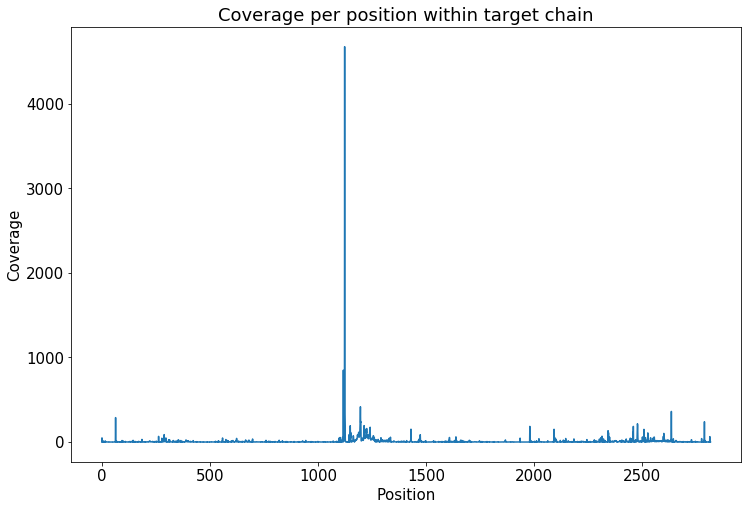

In [38]:
pd.Series(np.array(positions1)).plot()

width, height = 12, 8
mpl.rcParams['figure.figsize'] = [width, height]

plt.title("Coverage per position within target chain", size=18)
plt.xlabel("Position", size=15)
plt.ylabel("Coverage", size=15)

plt.xticks(size=15)
plt.yticks(size=15)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 <a list of 9 Text yticklabel objects>)

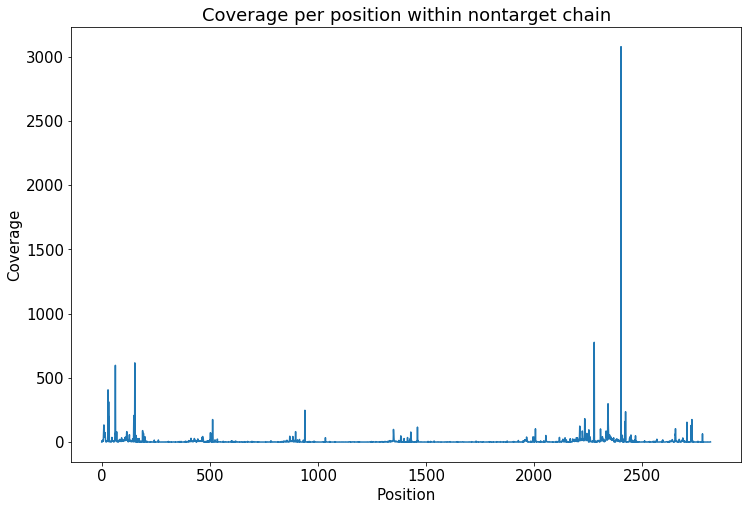

In [40]:
pd.Series(np.array(positions2)).plot()

plt.title("Coverage per position within nontarget chain", size=18)
plt.xlabel("Position", size=15)
plt.ylabel("Coverage", size=15)


plt.xticks(size=15)
plt.yticks(size=15)

Далее требовалось найти паттерны сайтов рестрикции, а для этого нужно было понять, какие нуклеотиды окружают наиболее покрытые концами ридов позиции.
В статье для визуализации результатов использовались теплокарты. Мы решили также использовать теплокарты и для того, чтобы их построить, отобрали 100 самых покрытых позиций на обеих цепях, исключая 3 наиболее покрытые.

In [26]:
# choosing best 100 start positions

target_chain = sorted(counter1.items(), key = lambda x: -x[1])
good_starts_f = list(map(lambda x: x[0], target_chain[3:100]))
#list of positions in f

nontarget_chain = sorted(counter2.items(), key = lambda x: -x[1])
good_starts_r = list(map(lambda x: x[0], nontarget_chain[3:100]))
#list of positions in r

Для дальнейшей работы определяется функция, строящая комплементарную цепочку для последовательности плазмиды из FASTA файла, и вырезающая из этой последовательности слова длины 6 (3 нуклеотида справа и 3 слева от позиции, хорошо покрытой концами ридов).

In [27]:
#convert position to bases for r chain

def pos_to_bases_r(fastafile, good_starts):
    with open (fastafile, 'r') as inp:
        inp.readline()
        string = ''
        for line in inp:
            line = line.strip()
            string = string + line
    genome_reverse = string[::-1]
    genome_rev = list(map(lambda x: {'T':'A', 'A':'T', 'C':'G', 'G':'C'}[x], genome_reverse))
    words= [string[el-3:el+3] for el in good_starts if len(string[el-3:el+3]) == 6] 
    return words


И функция, вырезающая из прямой последовательности слова длины 6 (3 нуклеотида справа и 3 слева от позиции, хорошо покрытой концами ридов).

In [28]:
#convert position to bases for f chain
def pos_to_bases_f(fastafile, good_starts):
    with open (fastafile, 'r') as inp:
        inp.readline()
        string = ''
        for line in inp:
            line = line.strip()
            string = string + line
    words= [string[el-3:el+3] for el in good_starts if len(string[el-3:el+3]) == 6] 
    return words


Получили список искомых слов для прямой и обратной цепей.

In [30]:
words_f = pos_to_bases_f("data/pGFP-PS8.fa", good_starts_f)
words_r = pos_to_bases_r("data/pGFP-PS8.fa", good_starts_r)

Вводится функция для подсчета частоты встречаемости букв на каждой позиции полученных словах.

In [31]:
#count bases in words

def gen_pos(words):
    list_of_dict = []
    for i in range(6):
        index_list = [el[i] for el in words]
        count = Counter(index_list)
        list_of_dict.append(count)
    return list_of_dict


Все посчитано.

In [32]:
list_of_dict_f = gen_pos(words_f)
list_of_dict_r = gen_pos(words_r)

Вводится функция для создания теплокарты и, собственно, строятся теплокарты, иллюстрирующие результаты работы.

In [33]:
# Create heatmap

def heatmap(list_of_dict):
    df = pd.DataFrame(list_of_dict)
    df = df.rename(index={0: -3, 1: -2, 2:-1, 3:1, 4:2, 5:3})
    sns.heatmap(df)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text yticklabel objects>)

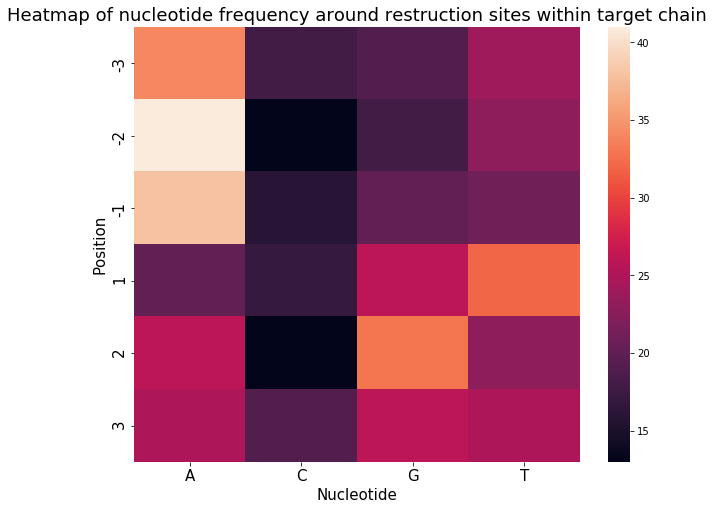

In [45]:
heatmap(list_of_dict_f)

width, height = 8, 6
mpl.rcParams['figure.figsize'] = [width, height]

plt.title("Heatmap of nucleotide frequency around restruction sites within target chain", size=18)
plt.xlabel("Nucleotide", size=15)
plt.ylabel("Position", size=15)


plt.xticks(size=15)
plt.yticks(size=15)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text yticklabel objects>)

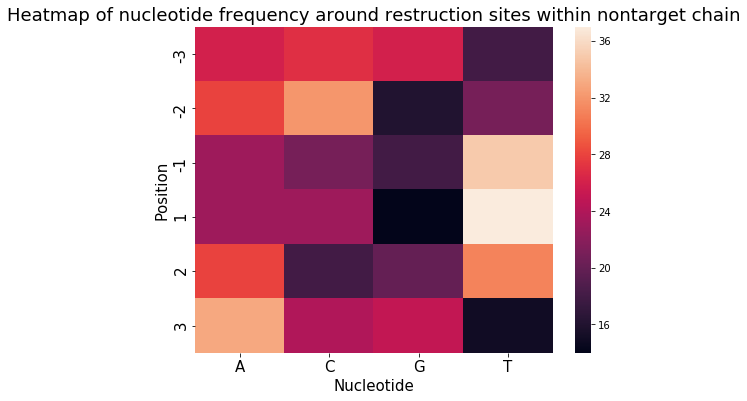

In [46]:
heatmap(list_of_dict_r)

plt.title("Heatmap of nucleotide frequency around restruction sites within nontarget chain", size=18)
plt.xlabel("Nucleotide", size=15)
plt.ylabel("Position", size=15)


plt.xticks(size=15)
plt.yticks(size=15)